# Supplemental Code for <br />  "Algorithms for Gibbs states preparation <br />  on noiseless and noisy random quantum circuits"

### Oles Shtanko<sup>1*</sup> and Ramis Movassagh<sup>2</sup>
<sup>1</sup>IBM Quantum, IBM Research-Almaden, San Jose CA, 95120 US\
<sup>2</sup>IBM Quantum, MIT-IBM Watson AI Lab, Cambridge MA, 02139 US

<sup>*</sup> oles.shtanko@ibm.com


## Table of Contents:

* [Dependencies](#dep)

* [Section 1: Simulations](#part1)
    * [Universal Algorithm](#part1.1)
         * [Setup](#a1_setup)
         * [Average density matrices (noiseless circuit)](#a1_avrg_noiseless)
         * [Average density matrices (noisy circuit)](#a1_avrg_noisy)
         * [Optimized circuit for error mitigation (noisy circuit)](#a1_optm)
         * [Generating plots](#a1_plots)
    * [Ergodic Algorithm](#part1.2)
         * [Setup](#a2_setup)
         * [Average density matrices (noiseless circuit)](#a2_avrg_noiseless)
         * [Average density matrices (noisy circuit)](#a2_avrg_noisy)
         * [Optimized circuit for error mitigation (noisy circuit)](#a2_optm)
         * [Generating plots](#a2_plots)

         

* [Section 2: Experiment on IBMQ hardware](#part2)
    * [Setting account](#part2.1)
    * [Universal Algorithm](#part2.2)
         * [Setup](#qa1_setup)
         * [Running experiment](#qa1_running_exp)
         * [Generating plots](#qa1_plot)
    * [Ergodic Algorithm](#part2.3)
         * [Setup](#qa2_setup)
         * [Running experiment](#qa2_running_exp)
         * [Generating plots](#qa2_plot)
    
---


## Dependencies  <a class="anchor" id="dep"></a>

### Original libraries

[Numpy](https://numpy.org/) 1.21.2\
[Matplotlib](https://scipy.org/) 3.4.3\
[Scipy](https://matplotlib.org/) 1.7.1\
[Qiskit](https://qiskit.org/) 0.29.0

More about Qiskit: https://www.ibm.com/quantum-computing/

In [5]:
import numpy
import scipy
import qiskit
import matplotlib

print('Your NumPy v',numpy.__version__)
print('Your Matplotlib v',matplotlib.__version__)
print('Your SciPy v',scipy.__version__)
print('Your Qiskit v',qiskit.__qiskit_version__['qiskit'])

Your NumPy v 1.20.1
Your Matplotlib v 3.3.4
Your SciPy v 1.6.2
Your Qiskit v 0.29.0


____

## Section 1: Simulations <a class="anchor" id="part1"></a>


Here we one-dimensional 1D hardcore-boson Hubbard model

$H = -J\sum_{j=1}^{N-1}(a^+_ja_{j+1}+a^+_{j+1}a_{j})+U\sum_{j=1}^Nn_j n_{j+1}$

where $a_i$ are hardcore-boson Fock operators, $\{a^+_i,a_j\} = 0$ for $i\neq j$ and $[a_i^+,a_i] = 1$.

This Hamiltonian can be mapped to the qubits as

$H = -J/2\sum_{i=1}^{N-1}(X_iX_{i+1}+Y_iY_{i+1})+U/4\sum_{i=1}^{N-1} Z_iZ_{i+1}+\sum_{i=1}^N h_i Z_i$

where $X_i$ and $Z_i$ are Pauli matrices acting on corresponding qubits, $h_i = -U/2$ for $i\neq 1,N$, and $h_1=h_{N} = -U/4$.

____


### Universal algorithm  <a class="anchor" id="part1.1"></a>


**Class:** `algrthm_1`

Parameters:

* `terms` list of one-qubit terms (2x2 matrices) and two-qubit terms (4x4 matrices). Matrices must be Hermitian.
* `qubits` list of indices for qubits subject to every term in `terms` (tuple)
* `ancilla` list of indices for ancilla qubits used to implement every term in `terms` (int)
* `beta_values` inverse temperature values
* `depth` the effective circuit depth
* `p2` error for two-qubit gate
* `p3` error for three-qubit gate

Methods:

* `.run()` run circuit for randomly-generated gates
    
* `.ham()` generate full Hamiltonian composed using the local terms
    
* `.Average_Case(samples)` evaluates the angle-average output
    Input: [samples] -- the number of samples in averaging
    Output: average density matrix

* `.Optimized_Case(samples)`evaluates optimized circuit and output\
    Input: [samples] -- number of steps in the Metropolis optimization\

### Universal algorithm: Setup <a class="anchor" id="a1_setup"></a>

In [3]:
import numpy as np
from source.algorithms import algrthm_1
from source.qstate2 import XX,YY,ZZ,Z

J = 1
U = 1

# create the circuit
circ = algrthm_1()

# choose inverse temperatures
beta_values = [0,0.5,1,1.5,2,2.5,3]

# assign the Hamiltonian terms
circ.terms = [-J/2*XX,-J/2*XX,-J/2*XX,-J/2*YY,-J/2*YY,-J/2*YY,U/4*ZZ,U/4*ZZ,U/4*ZZ,-U/4*Z,-U/2*Z,-U/2*Z,-U/4*Z]

# assign qubits for each term
circ.qubits = [[0,1],[1,2],[2,3],[0,1],[1,2],[2,3],[0,1],[1,2],[2,3],[0],[1],[2],[3]]

# assign respective ancillas for each term
circ.ancilla = [4,5,6,4,5,6,4,5,6,4,5,6,6]
        
# set the circuit depth
circ.depth = 10

# generate hamiltonian
circ.ham()

### Universal Algorithm: Average density matrices (noiseless circuit) <a class="anchor" id="a1_avrg_noiseless"></a>

In [2]:
from source.storage_v2 import savedata

# set gates error (for two- and three-qubit gates)
circ.p2 = 0.0
circ.p3 = 0.0

# set this TRUE to re-evaluate
evaluate = False

# set this TRUE to overwrite the data
save_data = True

#----

if evaluate:
    
    rho_avrg_noisy = np.empty(len(beta_values),np.ndarray)
    for bi in range(1,len(beta_values)):     
        circ.beta = beta_values[bi]
        rho_avrg_noisy[bi] = circ.Average_Case(samples = 1000)
    
    if savedata:
        savedata(rho_avrg_noisy,'data/simulations/algrthm1_noiseless')
     

### Universal Algorithm: Average density matrices (noisy circuit) <a class="anchor" id="a1_avrg_noisy"></a>

In [3]:
from source.storage_v2 import savedata

# set gates error (for two- and three-qubit gates)
circ.p2 = 0.01
circ.p3 = 0.02

# set this TRUE to re-evaluate
evaluate = False

# set this TRUE to overwrite the data
save_data = True

#----

if evaluate:
    
    rho_avrg_noisy = np.empty(len(beta_values),np.ndarray)
    for bi in range(1,len(beta_values)):
        circ.beta = beta_values[bi]
        rho_avrg_noisy[bi] = circ.Average_Case(samples = 1000)
    
    if savedata:
        savedata(rho_avrg_noisy,'data/simulations/algrthm1_noisy')
     

### Universal algorithm: optimized circuit for error mitigation (noisy circuit)  <a class="anchor" id="a1_optm"></a>

In [4]:
from source.storage_v2 import savedata

# set gates error (for two- and three-qubit gates)
circ.p2 = 0.01
circ.p3 = 0.02

# set this TRUE to re-evaluate
evaluate = False

# set this TRUE to overwrite the data
save_data = True

#---

if evaluate:
    
    rho_optm = np.empty(len(beta_values),np.ndarray)
    thetas_optm = np.empty(len(beta_values),np.ndarray)

    for bi in range(1,len(beta_values)):
        circ.beta = beta_values[bi]
        circ.thetas = np.ones([circ.depth,len(circ.terms)])
        rho_optm[bi] = circ.Optimized_Case(samples = 5000)
        thetas_optm[bi] = circ.thetas.copy()
        print()

    if savedata:
        savedata(rho_optm,'data/simulations/algrthm1_optimized')
        

### Universal algorithm: Generating plots  <a class="anchor" id="a1_plots"></a>

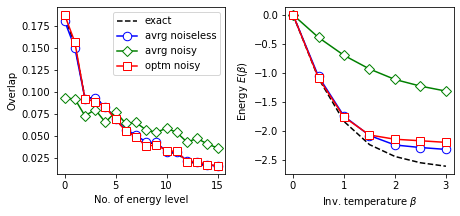

In [4]:
import matplotlib.pyplot as plt
from source.algorithms import processed_data

fig,ax = plt.subplots(1,2,figsize = (6.5,3.1))

# index for temperature array
indx = 1
pd = processed_data(circ.H,beta_values,indx,tp = 'algrthm1')

ax[0].plot(pd.gibbs_distr[indx],ls="--",c='k',label='exact')
ax[0].plot(pd.n_noiseless,marker = 'o',ms=8.5,c='b',mfc='w',label='avrg noiseless')
ax[0].plot(pd.n_noisy,marker = 'D',ms=7,c='g',mfc='w',label='avrg noisy')
ax[0].plot(pd.n_optimized,marker = 's',ms=7.5,c='r',mfc='w',label='optm noisy')
#------
ax[0].legend()
ax[0].set_ylabel('Overlap')
ax[0].set_xlabel('No. of energy level')
#------
ax[1].plot(beta_values,pd.E_gibbs,ls="--",c='k',label='exact')
ax[1].plot(beta_values,pd.E_noiseless,marker = 'o',ms=8.5,c='b',mfc='w')
ax[1].plot(beta_values,pd.E_noisy,marker = 'D',c='g',mfc='w',ms = 7)
ax[1].plot(beta_values,pd.E_optimized,marker = 's',ms=7.5,c='r',mfc='w')
ax[1].set_xlabel(r'Inv. temperature $\beta$')
ax[1].set_ylabel(r'Energy $E(\beta)$')

fig.tight_layout()

# save the plot to figs/simulations
plt.savefig("figs/simulations/fig1_top.svg", dpi=400)

plt.show()


---

##  Ergodic Algorithm  <a class="anchor" id="part1.2"></a>


**Class:** `algrthm_2`

Inputs:

* `n` number of system qubits in Hamiltonian *(int)* 
* `na` number of ancilla qubits *(int)* 

Parameters:

* `adj_matrix`  adjacency matrix reprenting ancilla-system couplings *((na $\times$ n) float)*
* `depth`  the effective circuit depth in terms of number of oracles *(int)* 
* `g`  error rate *(float)*
* `gamma`  inverse sycle time in Poisson distribution  *(float)*
* `lm`  interaction constant for first cycle *(float)*

Methods:

* `assign_hamiltonian(H)` inpust the Hamiltonian *((2^n $\times$ 2^n) complex)*
* `.Average_Case(samples)` evaluates the angle-average output\
    Input: samples -- the number of samples in averaging
    Output: average density matrix

* `.Optimized_Case(samples)`evaluates optimized circuit and output\
    Input: [samples] -- number of steps in the Metropolis optimization\
    Output: optimized circuit density matrix output\
    
### Ergodic Algorithm: Setup <a class="anchor" id="a2_setup"></a>

In [1]:
import numpy as np
from source.algorithms import algrthm_2
#from source.qstate2 import I,X,Z
from source.models import xxz_ham

t = 1
U = 1

#--------------------------------------------------------------------
# set the number of qubits and the number of ancillas
n  = 4 # number of qubits
na = 2 # number of ancillas

#--------------------------------------------------------------------
# create the circuit
circ = algrthm_2(n,na)

#--------------------------------------------------------------------
# choose inverse temperature values
beta_values = [0,0.5,1,1.5,2,2.5,3]

#--------------------------------------------------------------------
# setup the Hamiltonian
Jxx = [-t/2,-t/2,-t/2]
Jyy = [-t/2,-t/2,-t/2]
Jzz = [U/4,U/4,U/4]
hz  = [-U/4,-U/2,-U/2,-U/4]
H = xxz_ham(n,Jxx = Jxx,Jyy = Jyy,Jzz = Jzz,hz = hz)

circ.assign_hamiltonian(H)

#--------------------------------------------------------------------
# setup the adjancy matrix between ancilla and system qubits
circ.adj_matrix = np.zeros([na,n],int)
circ.adj_matrix[0,0] = 1
circ.adj_matrix[1,1] = 1

#--------------------------------------------------------------------
# setup depth (number of cycles)
circ.depth = 200

#--------------------------------------------------------------------
# interaction constant lambda
circ.lm = 0.05

#--------------------------------------------------------------------
# inverse cycle time (in Poisson distribution)
circ.gamma = 0.05

### Ergodic Algorithm: Average density matrices (noiseless circuit) <a class="anchor" id="a2_avrg_noiseless"></a>

In [6]:
from source.storage_v2 import savedata

#--------------------------------------------------------------------
# set this True to perform the computation 

evaluate = False

#--------------------------------------------------------------------
# set this to store/overwrite the data

save_data = True

#--------------------------------------------------------------------
# set depolarizing noise

circ.g = 0

if evaluate:
    
    rho_avrg_noisy = np.empty(len(beta_values),np.ndarray)

    for bi in range(1,len(beta_values)):
        circ.beta = beta_values[bi]
        rho_avrg_noisy[bi] = circ.Average_Case(samples = 1000)

    if save_data:
        savedata(rho_avrg_noisy,'data/simulations/algrthm2_noiseless')
            

### Ergodic Algorithm: Average density matrices (noisy circuit) <a class="anchor" id="a2_avrg_noisy"></a>

In [7]:
from source.storage_v2 import savedata

#--------------------------------------------------------------------
# set this True to perform the computation 

evaluate = False

#--------------------------------------------------------------------
# set this to store/overwrite the data

save_data = True

#--------------------------------------------------------------------
# set depolarizing noise

circ.g = 1e-3

if evaluate:
    
    rho_avrg_noisy = np.empty(len(beta_values),np.ndarray)

    for bi in range(1,len(beta_values)):
        circ.beta = beta_values[bi]
        rho_avrg_noisy[bi] = circ.Average_Case(samples = 1000)

    if save_data:
        savedata(rho_avrg_noisy,'data/simulations/algrthm2_noisy')
            

### Ergodic Algorithm: optimized circuit for error mitigation  <a class="anchor" id="a2_optm"></a>

In [8]:
from source.storage_v2 import savedata

#--------------------------------------------------------------------
# set this True to perform the computation 

evaluate = False

#--------------------------------------------------------------------
# set this to store/overwrite the data

save_data = True

#--------------------------------------------------------------------
# set depolarizing noise

circ.g = 1e-3

if evaluate:
    
    rho_optm = np.empty(len(beta_values),np.ndarray)
    beta_optm = np.empty(len(beta_values),np.ndarray)
    omegas_optm = np.empty(len(beta_values),np.ndarray)
    X_coupling_optm = np.empty(len(beta_values),np.ndarray)
    Z_coupling_optm = np.empty(len(beta_values),np.ndarray)
    time_schedule_optm = np.empty(len(beta_values),np.ndarray)

    for bi in range(1,len(beta_values)):

        #print(r'Computing beta = '+str(beta_values[bi]))
        circ.beta = beta_values[bi]
        circ.set_random_schedule()
        circ.Optimized_Case(samples = 1000) 

        rho_optm[bi] = circ.state
    
    if save_data:
        savedata(rho_optm,'data/simulations/algrthm2_optimized')
        

### Ergodic Algorithm: Generating plots  <a class="anchor" id="a2_plots"></a>

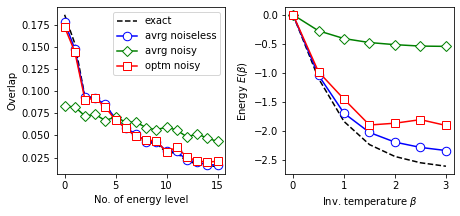

In [9]:
import matplotlib.pyplot as plt
from source.algorithms import processed_data

fig,ax = plt.subplots(1,2,figsize = (6.5,3.1))

# index for temperature array
indx = 1
pd = processed_data(circ.H,beta_values,indx,tp = 'algrthm2')

ax[0].plot(pd.gibbs_distr[indx],ls="--",c='k',label='exact')
ax[0].plot(pd.n_noiseless,marker = 'o',ms=8.5,c='b',mfc='w',label='avrg noiseless')
ax[0].plot(pd.n_noisy,marker = 'D',ms=7,c='g',mfc='w',label='avrg noisy')
ax[0].plot(pd.n_optimized,marker = 's',ms=7.5,c='r',mfc='w',label='optm noisy')
#------
ax[0].legend()
ax[0].set_ylabel('Overlap')
ax[0].set_xlabel('No. of energy level')
#------
ax[1].plot(beta_values,pd.E_gibbs,ls="--",c='k',label='exact')
ax[1].plot(beta_values,pd.E_noiseless,marker = 'o',ms=8.5,c='b',mfc='w')
ax[1].plot(beta_values,pd.E_noisy,marker = 'D',c='g',mfc='w',ms = 7)
ax[1].plot(beta_values,pd.E_optimized,marker = 's',ms=7.5,c='r',mfc='w')
ax[1].set_xlabel(r'Inv. temperature $\beta$')
ax[1].set_ylabel(r'Energy $E(\beta)$')

fig.tight_layout()

# save the plot to figs/simulations
plt.savefig("figs/simulations/fig2_bottom.svg", dpi=400)

plt.show()

## Section 2: Experiment on IBMQ hardware <a class="anchor" id="part2"></a>


### Setting account: <a class="anchor" id="part2.1"></a> 

In [10]:
from qiskit import IBMQ
import getpass

api_key = getpass.getpass('Enter your API key: ')
IBMQ.save_account(api_key,overwrite=True)
IBMQ.load_account()

Enter your API key: ········


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### Universal Algorithm with Qiskit <a class="anchor" id="part2.2"></a>

Here we study 1D Heisenberg Hamiltonian

$H = J\sum_{i=1}^{N-1}(X_iX_{i+1}+Y_iY_{i+1}+Z_iZ_{i+1})+\mu\sum_{i=1}^NZ_i$

where $X_i$ and $Z_i$ are Pauli matrices acting on corresponding qubits. We divide it using local terms $\{JX_1X_2,\mu_1Z_1,\mu_2Z_2,h_1X_1,h_2X_2\}$. 

### Universal Algorithm with Qiskit: Setup  <a class="anchor" id="qa1_setup"></a>

In [5]:
import numpy as np
from qiskit import IBMQ
from source.algorithms import qiskit_algrthm1
from source.qstate2 import I,X,Z

# create experimental circuit object
circ = qiskit_algrthm1()

# setting system and ancilla qubits
circ.sys_qubits = [1,3]
circ.ancillas = [0,2,4]
circ.layout = [0,1,3,5,6]

# set the terms
circ.terms = ['xx','z','z']

# set corresponding coefficients
circ.coefs = [1,-1.0,-1.0]

# set the qubits for each term
circ.subj_qubits = [[1,3],[1],[3]]

# set the ancilla for each term, consider connectivity
circ.subj_ancilla = [0,4,2]

# inverse temperature
circ.beta = 1

# circuit depth
circ.depth = 5

# number of (randomly generated) circuits
circ.circuits = 100

# number of measurement shots per circuit
circ.shots = 8192

circ.ham()

### Universal Algorithm with Qiskit: Running experiment <a class="anchor" id="qa1_running_exp"></a>

In [5]:
# ----------------------------------
# Run the simulation/experiment
#-----------------------------------

#--------------------------------------------------------------------
# set this True to perform the computation 

evaluate = False

#--------------------------------------------------------------------
# set this to store/overwrite the data

save_data = True

if evaluate:
    
    # load your account
    IBMQ.load_account()

    # setting device
    circ.provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
    circ.device = 'ibmq_casablanca'

    # choose simulation ('simulator') or actual IBMQ device ('device')
    circ.run_type = 'device'

    # if using simulator, you can add simulated noise from the device
    circ.noise = True

    circ.update_thetas()

    circ.run()

    # ----------------------------------
    # Save the data
    #-----------------------------------
    
    if save_data = True:
        
        filename = 'data/qiskit/algorithm1.npy'
        data_container = {'X data':circ.samples_x,'Z data':circ.samples_z}
        np.save(filename,data_container) 
        print('Saved!')

ibmqfactory.load_account:WARNING:2021-12-28 15:05:16,076: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run
Saved!


### Universal Algorithm with Qiskit: Generating Plot  <a class="anchor" id="qa1_plot"></a>

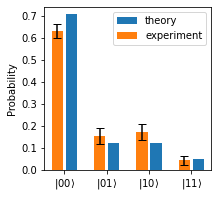

In [7]:
import sys
from itertools import product
import matplotlib.pyplot as plt

filename = 'data/qiskit/algorithm1.npy'
data_container = np.load(filename,allow_pickle=True).tolist() 
samples_x = data_container['X data']
samples_z = data_container['Z data']

circ.n = len(circ.sys_qubits)
circ.na = len(circ.ancillas)

n = circ.n
#--------------------------------------------------------------------
# clalculation of sampling probabilities for output state -- average
#--------------------------------------------------------------------

# finding sampling size
size = int(len(samples_z)/circ.n)

# define index of each output state
indx = np.zeros(size,int)
for i in range(n):
    indx += samples_z[i::n]*2**i

#finding output sampling probabilities counting indices
out_samp_prob = np.zeros(2**n)
out_samp_prob_err = np.zeros(2**n)
for j in range(2**n):
    out_samp_prob[j] = np.count_nonzero(indx==j)/size
    out_samp_prob_err[j] = np.sqrt(out_samp_prob[j])\
                            *(1-out_samp_prob[j])*(1/np.sqrt(circ.circuits)+1/np.sqrt(circ.shots))
    
#----------------------------------------------------------------
# clalculation of sampling probabilities for Gibbs distribution
#----------------------------------------------------------------

# generatiion of Hamiltonian
H = circ.H

# generatiion of Hamiltonian
E,Q = np.linalg.eigh(H)

# finding Gibbs distribution (in eigenbasis)
gibbs_distr = np.exp(-circ.beta*E)/np.sum(np.exp(-circ.beta*E))

# finding sampling probabilities in Z-basis
gibbs_samp_prob = np.diag(np.dot(Q,np.dot(np.diag(gibbs_distr),Q.T.conj()))).real

#-----------------------------------------------------------
# plotting
#-----------------------------------------------------------

fig,ax = plt.subplots(figsize = (3,3))

# assingment of bar heights such that they plave next to each other
red_bars_positions  = np.arange(3*2**n-1)[::3] 
blue_bars_positions = np.arange(3*2**n-1)[1::3]

# making bar plot
ax.bar(blue_bars_positions,gibbs_samp_prob,label='theory')
ax.bar(red_bars_positions,out_samp_prob,yerr = out_samp_prob_err,capsize=4.0,label='experiment')

# generating state labels
labels = []
label_list = list(product('01', repeat = n))
for k in label_list:
    labels.append('|'+''.join(k)+r'$\rangle$')

#setting plot
ax.set_xticks(3*np.arange(2**n)+0.5)
ax.set_xticklabels(labels)
ax.set_ylabel('Probability')
ax.legend()

plt.savefig('figs/qiskit/algorithm1.svg',dpi=350)
plt.show()

Let us now extract the internal energy of the prepared state and compare it to the theoretical value predicted by the Gibbs distribution.

### Ergodic Algorithm with Qiskit <a class="anchor" id="part2.3"></a>


In [8]:
import numpy as np
from qiskit import IBMQ
from source.algorithms import qiskit_algrthm2
from source.qstate2 import I,X,Z

n  = 1 # number of qubits
na = 1 # number of ancillas

# initiate empty circuit
circ = qiskit_algrthm2(n,na)

# =========== Setting IBMQ device ============

# list of device's qubits that serve as system qubits (see Fig.)
circ.sys_qubits = [0]
# list of device's qubits that serve as ancillas
circ.ancillas = [1]
# setting adjacency matrix between system qubits and ancillas
circ.adj_matrix = np.zeros([na,n],int)
circ.adj_matrix[0,0] = 1

# =========== Setting system parameters ============

# desired Hamiltonian
circ.H = 1.0*Z

# inverse temperature
circ.beta  = 1

# depth (number of oracles)
circ.depth = 5

# average inverse oracle time
circ.gamma = 0.1

circ.lm0 = 0.1
circ.T0 = 100

circ.set_L_schedule(tp = 'linear')
circ.set_T_schedule(tp = 'const')
circ.set_V_schedule()

### Ergodic Algorithm with Qiskit: Running experiment <a class="anchor" id="qa2_running_exp"></a>

In [3]:
#--------------------------------------------------------------------
# set this True to perform the computation 

evaluate = False

#--------------------------------------------------------------------
# set this to store/overwrite the data

save_data = True

if evaluate:
    
    # load your account
    IBMQ.load_account()

    # choose available provider (choose yours)
    circ.provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')

    # choose simulation ('simulator') or actual IBMQ device ('device')
    circ.run_type = 'device'

    # choose device
    circ.device = 'ibmq_casablanca'

    # if using simulator, this option adds simulated noise
    circ.noise = True

    # number of (randomly generated) circuits
    circ.circuits = 150

    # number of measurement shots per circuit
    circ.shots = 8192

    circ.run()

    if save_data = True:
        
        filename = 'data/qiskit/algorithm2.npy'
        data_container = {'X data':circ.samples_x,'Z data':circ.samples_z}
        np.save(filename,data_container) 
        print('Saved!')

ibmqfactory.load_account:WARNING:2021-12-28 18:43:03,423: Credentials are already in use. The existing account in the session will be replaced.


### Ergodic Algorithm with Qiskit: Generating Plot  <a class="anchor" id="qa2_plot"></a>

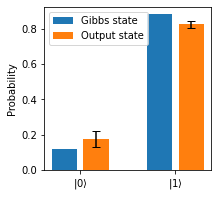

In [9]:
import sys
from itertools import product
import matplotlib.pyplot as plt

filename = 'data/qiskit/algorithm2.npy'
data_container = np.load(filename,allow_pickle=True).tolist() 
samples_x = 1-data_container['X data']
samples_z = 1-data_container['Z data']

#----------------------------------------------------------------
# clalculation of sampling probabilities for output state
#----------------------------------------------------------------

# finding sampling size
size = int(len(samples_z)/n)

# define index of each output state
indx = np.zeros(size,int)
if n==1:
    indx = samples_z
if n>1:
    for i in range(n):
        indx += samples_z[i::n]*2**i

#finding output sampling probabilities counting indices
out_samp_prob = np.zeros(2**n)
out_samp_prob_err = np.zeros(2**n)
for j in range(2**n):
    out_samp_prob[j] = np.count_nonzero(indx==j)/size
    out_samp_prob_err[j] = np.sqrt(out_samp_prob[j])\
                            *(1-out_samp_prob[j])*(1/np.sqrt(circ.circuits)+1/np.sqrt(circ.shots))
    
#----------------------------------------------------------------
# clalculation of sampling probabilities for Gibbs distribution
#----------------------------------------------------------------

# generatiion of Hamiltonian
E,Q = np.linalg.eigh(circ.H)

# finding Gibbs distribution (in eigenbasis)
gibbs_distr = np.exp(-circ.beta*E)/np.sum(np.exp(-circ.beta*E))

# finding sampling probabilities in Z-basis
gibbs_samp_prob = np.diag(np.dot(Q,np.dot(np.diag(gibbs_distr),Q.T.conj()))).real

#-----------------------------------------------------------
# plotting
#-----------------------------------------------------------

fig,ax = plt.subplots(figsize = (3,3))

# assingment of bar heights such that they plave next to each other
red_bars_positions  = np.arange(3*2**n-1)[1::3] 
blue_bars_positions = np.arange(3*2**n-1)[::3]

# making bar plot
ax.bar(blue_bars_positions,gibbs_samp_prob,label='Gibbs state')
ax.bar(red_bars_positions,out_samp_prob,yerr = out_samp_prob_err,capsize=4.0,label='Output state')

# generating state labels
labels = []
label_list = list(product('01', repeat = n))
for k in label_list:
    labels.append('|'+''.join(k)+r'$\rangle$')

#setting plot
ax.set_xticks(3*np.arange(2**n)+0.5)
ax.set_xticklabels(labels)
ax.set_ylabel('Probability')
ax.legend()

plt.savefig('figs/qiskit/algorithm2.svg',dpi=350)
plt.show()